# Import Libraries

In [1]:
# For drive access
from google.colab import drive
drive.mount('/content/drive')

# Standard libraries
import numpy as np
import pandas as pd

# for loading the pickle files with features and labels
import pickle

# For audio
from IPython.display import Audio
import librosa

# For modeling
import tensorflow as tf
from sklearn.metrics import classification_report

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Method:

Use the entire training set (train + val) to train the model using the selected hyperparameters and use the weights from the final trained model to run inference using the test set.

# Load features and labels from train and val pickle

In [2]:
with open('/content/drive/MyDrive/Projects/train_val_features_pkl/train_val_8_sec_audio_features_not_avgpooled.pkl', 'rb') as file:
  audio_df = pickle.load(file)

In [3]:
audio_df

{'train': {'mfcc': array([[[0.2926833 , 0.5472208 , 0.51762646, ..., 0.42902297,
           0.5246572 , 0.39747417],
          [0.38219857, 0.63193434, 0.4692648 , ..., 0.4789598 ,
           0.5143834 , 0.35231233],
          [0.4352324 , 0.62795496, 0.4937711 , ..., 0.53823024,
           0.5205363 , 0.36665156],
          ...,
          [0.6295364 , 0.3740691 , 0.4684327 , ..., 0.74904454,
           0.6659465 , 0.13212648],
          [0.6729512 , 0.37194872, 0.47004578, ..., 0.63276273,
           0.6894711 , 0.25973636],
          [0.6984098 , 0.35604227, 0.50428545, ..., 0.49908003,
           0.694181  , 0.40737295]],
  
         [[0.571982  , 0.52721703, 0.35377806, ..., 0.31411108,
           0.45345846, 0.5325761 ],
          [0.57278824, 0.51283437, 0.33133256, ..., 0.44663262,
           0.59104645, 0.5540432 ],
          [0.5442881 , 0.50030595, 0.39622635, ..., 0.4177069 ,
           0.63780564, 0.5152073 ],
          ...,
          [0.65820706, 0.30996823, 0.5541669 , ..

In [4]:
with open('/content/drive/MyDrive/Projects/train_val_features_pkl/train_val_8_sec_non_audio_features.pkl', 'rb') as file:
  non_audio_df = pickle.load(file)

In [5]:
non_audio_df

{'train': {'type': array(['blank', 'blank', 'blank', ..., 'blank', 'blank', 'blank'],
        dtype='<U5'),
  'continent': array(['AFRICA', 'AFRICA', 'AFRICA', ..., 'EUROPE', 'EUROPE', 'EUROPE'],
        dtype='<U8'),
  'rating': array([5., 5., 5., ..., 5., 5., 5.]),
  'label': array([0, 0, 0, ..., 2, 2, 2])},
 'val': {'type': array(['song', 'call', 'call', ..., 'blank', 'call', 'call'], dtype='<U5'),
  'continent': array(['EUROPE', 'EUROPE', 'EUROPE', ..., 'EUROPE', 'EUROPE', 'EUROPE'],
        dtype='<U8'),
  'rating': array([3.5, 5. , 4. , ..., 5. , 3. , 3. ]),
  'label': array([0, 0, 1, ..., 2, 1, 2])}}

## confirm the audio features and non_audio features labels line-up

In [6]:
assert np.array_equal(audio_df['train']['label'], non_audio_df['train']['label'])

In [7]:
assert np.array_equal(audio_df['val']['label'], non_audio_df['val']['label'])

# Combine Train and Val into one large train df

In [8]:
audio_df['train'].keys()

dict_keys(['mfcc', 'chroma', 'rms', 'spectral_centroid', 'melspectrogram', 'label'])

In [9]:
def combined(train_dict, val_dict):
  comb_dict = {}
  for key in train_dict.keys():
    train = train_dict[key]
    val = val_dict[key]
    comb_dict[key] = np.concatenate((train, val), axis=0)

  return comb_dict

In [10]:
audio_train = combined(audio_df['train'], audio_df['val'])
non_audio_train = combined(non_audio_df['train'], non_audio_df['val'])

In [11]:
assert len(audio_train['label']) == len(audio_df['train']['label']) + len(audio_df['val']['label'])
assert len(non_audio_train['label']) == len(non_audio_df['train']['label']) + len(non_audio_df['val']['label'])

# Load the test df

In [12]:
with open('/content/drive/MyDrive/Projects/test_features_pkl/test_8_sec_audio_features_not_avgpooled.pkl', 'rb') as file:
  audio_df = pickle.load(file)

In [13]:
with open('/content/drive/MyDrive/Projects/test_features_pkl/test_8_sec_non_audio_features.pkl', 'rb') as file:
  non_audio_df = pickle.load(file)

# Shuffle the data

In [14]:
def shuffle_data(audio_features, non_audio_features):
  input_len = len(audio_features['label'])
  input_indices = np.random.permutation(input_len)
  audio_features = {key: np.array([audio_features[key][i] for i in input_indices]) for key in audio_features}
  non_audio_features = {key: np.array([non_audio_features[key][i] for i in input_indices]) for key in non_audio_features}

  return audio_features, non_audio_features

In [15]:
audio_df['train'], non_audio_df['train'] = shuffle_data(audio_train, non_audio_train)

In [16]:
for key in audio_df['train'].keys():
  display(key)
  display(audio_df['train'][key].shape)
  display(audio_df['train'][key][:5])

'mfcc'

(7193, 251, 20)

array([[[0.31340706, 0.5083903 , 0.5032574 , ..., 0.47774494,
         0.47651088, 0.42652678],
        [0.32438284, 0.41206852, 0.48762417, ..., 0.570858  ,
         0.4737267 , 0.6061802 ],
        [0.34916884, 0.33925712, 0.5454498 , ..., 0.65788877,
         0.4985978 , 0.5933492 ],
        ...,
        [0.46796864, 0.23406002, 0.51061004, ..., 0.47544762,
         0.5244436 , 0.4592968 ],
        [0.4972143 , 0.22366896, 0.5349345 , ..., 0.46601638,
         0.4797125 , 0.45000505],
        [0.5509628 , 0.22584033, 0.60882807, ..., 0.48243523,
         0.50794125, 0.4882752 ]],

       [[0.789883  , 0.8197867 , 0.81968224, ..., 0.39927503,
         0.53630704, 0.6208297 ],
        [0.7406917 , 0.80212444, 0.76475286, ..., 0.5197168 ,
         0.49913788, 0.66565907],
        [0.6818242 , 0.74754906, 0.7756066 , ..., 0.5783277 ,
         0.46531022, 0.5576756 ],
        ...,
        [0.64258385, 0.71727556, 0.69103974, ..., 0.4905902 ,
         0.5331884 , 0.39405066],
        [0.6

'chroma'

(7193, 251, 12)

array([[[0.3830355 , 0.8554258 , 0.9071383 , ..., 0.3229036 ,
         0.27756673, 0.27062443],
        [0.21434113, 0.45309705, 0.60563564, ..., 0.40009984,
         0.5506512 , 0.20295757],
        [0.8003785 , 0.76179004, 0.8767364 , ..., 0.85045433,
         0.71807957, 0.541028  ],
        ...,
        [0.5490665 , 0.49312916, 0.6592992 , ..., 0.97006416,
         0.8262135 , 0.59013706],
        [0.45593023, 0.5809928 , 0.6571944 , ..., 0.9260771 ,
         1.0000001 , 0.7644399 ],
        [0.40191796, 0.6671458 , 0.8352444 , ..., 0.956495  ,
         1.        , 0.5847202 ]],

       [[0.49285713, 0.8328068 , 0.982948  , ..., 0.424801  ,
         0.6067671 , 0.5283773 ],
        [0.58449215, 0.6166787 , 0.68557143, ..., 0.2979732 ,
         0.42231467, 0.45004746],
        [0.46573618, 0.32971382, 0.5512974 , ..., 0.41856822,
         0.31399634, 0.2950641 ],
        ...,
        [0.5026945 , 0.26855546, 0.24716726, ..., 0.27342507,
         0.39889196, 0.43062136],
        [0.5

'rms'

(7193, 251, 1)

array([[[0.00070369],
        [0.00138696],
        [0.00698515],
        ...,
        [0.01462037],
        [0.01470003],
        [0.01422181]],

       [[0.11294401],
        [0.11715928],
        [0.13386339],
        ...,
        [0.07085819],
        [0.03557923],
        [0.02437059]],

       [[0.01838574],
        [0.017507  ],
        [0.01954742],
        ...,
        [0.01172828],
        [0.01205861],
        [0.01185123]],

       [[0.10649057],
        [0.12800163],
        [0.12666413],
        ...,
        [0.01009319],
        [0.00885304],
        [0.00646046]],

       [[0.00407658],
        [0.00635892],
        [0.00800999],
        ...,
        [0.0096248 ],
        [0.0088746 ],
        [0.0075958 ]]], dtype=float32)

'spectral_centroid'

(7193, 251, 1)

array([[[0.60077354],
        [0.60508563],
        [0.63514213],
        ...,
        [0.67003402],
        [0.62795531],
        [0.61794979]],

       [[0.15598254],
        [0.13405792],
        [0.1264167 ],
        ...,
        [0.16936738],
        [0.2077698 ],
        [0.18339359]],

       [[0.1946061 ],
        [0.2783417 ],
        [0.32822663],
        ...,
        [0.25851962],
        [0.22104409],
        [0.20936412]],

       [[0.68997151],
        [0.69083214],
        [0.69417787],
        ...,
        [0.52624827],
        [0.52863363],
        [0.53714248]],

       [[0.35117188],
        [0.35399013],
        [0.39654384],
        ...,
        [0.37065956],
        [0.37563613],
        [0.4078419 ]]])

'melspectrogram'

(7193, 251, 20)

array([[[0.2764626 , 0.2357136 , 0.20780158, ..., 0.24629688,
         0.21395028, 0.22554058],
        [0.2655425 , 0.18406057, 0.18239605, ..., 0.33027467,
         0.27472287, 0.28433824],
        [0.26440924, 0.19624537, 0.17418987, ..., 0.4350118 ,
         0.34068078, 0.35597748],
        ...,
        [0.28720474, 0.19613338, 0.1718573 , ..., 0.55115855,
         0.5493965 , 0.5412948 ],
        [0.30825305, 0.24725169, 0.23278427, ..., 0.5676671 ,
         0.56137323, 0.54404455],
        [0.38607126, 0.31997788, 0.30971974, ..., 0.60307527,
         0.5791502 , 0.54327863]],

       [[0.8660905 , 0.87338674, 0.8346401 , ..., 0.65913534,
         0.5780883 , 0.50795245],
        [0.8466052 , 0.8761033 , 0.8306142 , ..., 0.60562277,
         0.5535427 , 0.49569714],
        [0.8410639 , 0.8754088 , 0.80295926, ..., 0.574794  ,
         0.5342103 , 0.5004161 ],
        ...,
        [0.849798  , 0.7863156 , 0.6804723 , ..., 0.45677683,
         0.44935426, 0.4310587 ],
        [0.8

'label'

(7193,)

array([2, 2, 2, 0, 1])

In [17]:
for key in non_audio_df['train'].keys():
  display(key)
  display(non_audio_df['train'][key].shape)
  display(non_audio_df['train'][key][:5])

'type'

(7193,)

array(['both', 'song', 'song', 'song', 'call'], dtype='<U5')

'continent'

(7193,)

array(['ASIA', 'EUROPE', 'EUROPE', 'AMERICAS', 'EUROPE'], dtype='<U8')

'rating'

(7193,)

array([4. , 2.5, 5. , 3.5, 3. ])

'label'

(7193,)

array([2, 2, 2, 0, 1])

In [18]:
audio_df['test'], non_audio_df['test'] = shuffle_data(audio_df['test'], non_audio_df['test'])

In [19]:
for key in audio_df['test'].keys():
  display(key)
  display(audio_df['test'][key].shape)
  display(audio_df['test'][key][:5])

'mfcc'

(3402, 251, 20)

array([[[0.05751836, 0.5444168 , 0.51480824, ..., 0.39912894,
         0.32411   , 0.3102708 ],
        [0.3264776 , 0.58581823, 0.43157333, ..., 0.3925634 ,
         0.35503167, 0.4760821 ],
        [0.5008652 , 0.59305197, 0.50153375, ..., 0.5518851 ,
         0.594192  , 0.5294669 ],
        ...,
        [0.6277363 , 0.65121   , 0.54693687, ..., 0.48097464,
         0.62421703, 0.5553329 ],
        [0.6279348 , 0.6612489 , 0.53767145, ..., 0.48681247,
         0.5776012 , 0.5238315 ],
        [0.62708324, 0.64345163, 0.52916586, ..., 0.50196135,
         0.571861  , 0.4465344 ]],

       [[0.05753565, 0.5349221 , 0.5197002 , ..., 0.4159525 ,
         0.53506   , 0.3903076 ],
        [0.20844102, 0.4415317 , 0.36344025, ..., 0.50361854,
         0.5551747 , 0.5968758 ],
        [0.3701837 , 0.41131276, 0.36254627, ..., 0.630756  ,
         0.5920049 , 0.5559908 ],
        ...,
        [0.6215415 , 0.4296014 , 0.371166  , ..., 0.37629867,
         0.4886013 , 0.38232976],
        [0.6

'chroma'

(3402, 251, 12)

array([[[0.8009532 , 0.75713205, 0.87019414, ..., 0.93207866,
         0.77794504, 0.69804186],
        [0.44944936, 0.44159278, 0.48957652, ..., 0.79600286,
         1.        , 0.5952274 ],
        [0.52090645, 0.66748255, 0.53397036, ..., 0.67929125,
         1.        , 0.6914094 ],
        ...,
        [0.44830716, 0.47670165, 0.584808  , ..., 1.        ,
         0.74409467, 0.62880135],
        [0.6818338 , 0.65670174, 0.75234246, ..., 0.9778203 ,
         0.90000015, 0.64989066],
        [0.7829898 , 0.67753637, 0.7815017 , ..., 0.99999994,
         0.82402545, 0.6325813 ]],

       [[0.7633385 , 0.7430131 , 0.77502024, ..., 0.73625237,
         0.99999994, 0.84770095],
        [0.9567628 , 1.        , 0.611546  , ..., 0.97700393,
         0.7539354 , 0.67149174],
        [0.7577875 , 0.81983477, 0.6588649 , ..., 1.        ,
         0.6677291 , 0.5480473 ],
        ...,
        [0.8086127 , 0.8940417 , 1.        , ..., 0.8575036 ,
         0.7104405 , 0.8541914 ],
        [0.6

'rms'

(3402, 251, 1)

array([[[8.9872367e-05],
        [1.5724476e-03],
        [2.9318000e-03],
        ...,
        [7.2314041e-03],
        [6.8401047e-03],
        [5.5734664e-03]],

       [[5.8282600e-05],
        [6.9019169e-04],
        [1.5394890e-03],
        ...,
        [1.7329810e-02],
        [1.1462551e-02],
        [9.5769018e-03]],

       [[5.9136259e-03],
        [6.8405611e-03],
        [7.0698904e-03],
        ...,
        [6.2375115e-03],
        [5.8538383e-03],
        [5.1620975e-03]],

       [[1.9137925e-02],
        [1.8857991e-02],
        [1.9963529e-02],
        ...,
        [5.0350693e-03],
        [4.5259274e-03],
        [3.8921642e-03]],

       [[1.5684741e-02],
        [1.7978380e-02],
        [1.8927377e-02],
        ...,
        [1.2126342e-02],
        [1.1979389e-02],
        [8.4182983e-03]]], dtype=float32)

'spectral_centroid'

(3402, 251, 1)

array([[[0.5250859 ],
        [0.42962684],
        [0.42360964],
        ...,
        [0.3588673 ],
        [0.36268654],
        [0.35632832]],

       [[0.57684101],
        [0.57431003],
        [0.57158689],
        ...,
        [0.54261077],
        [0.52234304],
        [0.53548615]],

       [[0.54627009],
        [0.5481935 ],
        [0.56993294],
        ...,
        [0.54585411],
        [0.56811711],
        [0.57028179]],

       [[0.16167508],
        [0.1733709 ],
        [0.24202892],
        ...,
        [0.34856987],
        [0.36716545],
        [0.36436531]],

       [[0.24421339],
        [0.29334334],
        [0.32084221],
        ...,
        [0.31440086],
        [0.32268429],
        [0.31662807]]])

'melspectrogram'

(3402, 251, 20)

array([[[0.18909222, 0.13050997, 0.04422539, ..., 0.03370881,
         0.02399981, 0.04572511],
        [0.3950938 , 0.31381112, 0.30695218, ..., 0.22820473,
         0.20920879, 0.20350087],
        [0.5030843 , 0.4706566 , 0.46276787, ..., 0.36219424,
         0.35240325, 0.35581177],
        ...,
        [0.64337444, 0.6314495 , 0.63056123, ..., 0.44323012,
         0.44483957, 0.4265015 ],
        [0.62995315, 0.6191312 , 0.616823  , ..., 0.42738187,
         0.45239785, 0.43274382],
        [0.6259765 , 0.60502565, 0.5810087 , ..., 0.41818744,
         0.45059264, 0.4158802 ]],

       [[0.10710728, 0.04100668, 0.04791617, ..., 0.03768796,
         0.03716892, 0.04923409],
        [0.11668366, 0.06345254, 0.11027271, ..., 0.19996208,
         0.18986958, 0.19350815],
        [0.19874328, 0.21697193, 0.24951631, ..., 0.33793798,
         0.3316696 , 0.34322357],
        ...,
        [0.42632422, 0.43502498, 0.4905563 , ..., 0.53744906,
         0.5621266 , 0.5467236 ],
        [0.4

'label'

(3402,)

array([2, 2, 2, 2, 0])

In [20]:
for key in non_audio_df['test'].keys():
  display(key)
  display(non_audio_df['test'][key].shape)
  display(non_audio_df['test'][key][:5])

'type'

(3402,)

array(['call', 'both', 'call', 'song', 'both'], dtype='<U5')

'continent'

(3402,)

array(['EUROPE', 'EUROPE', 'EUROPE', 'EUROPE', 'EUROPE'], dtype='<U8')

'rating'

(3402,)

array([3. , 2. , 4.5, 4.5, 4. ])

'label'

(3402,)

array([2, 2, 2, 2, 0])

# Create sample weights based on rating

In [21]:
training_sample_weights = non_audio_df['train']['rating']

training_sample_weights

array([4. , 2.5, 5. , ..., 5. , 5. , 5. ])

In [22]:
test_sample_weights = non_audio_df['test']['rating']

test_sample_weights

array([3. , 2. , 4.5, ..., 3. , 3. , 2.5])

In [23]:
training_sample_weights = np.where(training_sample_weights > 3.0, 0.6, 0.4)

training_sample_weights

array([0.6, 0.4, 0.6, ..., 0.6, 0.6, 0.6])

In [24]:
test_sample_weights = np.where(test_sample_weights > 3.0, 0.6, 0.4)

test_sample_weights

array([0.4, 0.4, 0.6, ..., 0.4, 0.4, 0.4])

# 1D CNN Models

In [25]:
classes = ['barswa', 'comsan', 'eaywag1']

## Create 1D CNN model function

In [26]:
np.unique(non_audio_df['train']['continent'])

array(['AFRICA', 'AMERICAS', 'ASIA', 'EUROPE', 'UNKNOWN'], dtype='<U8')

In [27]:
def build_model(audio_features,
                continent_feature,
                learning_rate=0.001):

  tf.keras.backend.clear_session()

  # set audio features input layer
  audio_features = tf.keras.layers.Input(shape=(audio_features.shape[1],audio_features.shape[2]), name='Audio_Features')

  # set continent features input layer
  location = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Continents')
  location_binned = tf.keras.layers.StringLookup(vocabulary=np.unique(continent_feature))(location)
  location_embed = tf.keras.layers.Embedding(input_dim=(len(np.unique(continent_feature))+1), output_dim=2, input_length=1)(location_binned)

  # custom function to tile the 'Location' embeddings to match the time steps of audio features
  def tile_location_embed(x):
      return tf.keras.backend.tile(x, [1, audio_features.shape[1], 1])

  # using the Lambda layer with the custom function
  location_embed = tf.keras.layers.Lambda(tile_location_embed, name='Tile')(location_embed)

  # create features using both continents with embeddings and mfccs
  features = tf.keras.layers.Concatenate(axis=2, name='Features')([location_embed, audio_features])

  # add first convolution layer to the model
  features = tf.keras.layers.Conv1D(
              filters=32,
              kernel_size=5,
              strides=1,
              padding='same',
              data_format='channels_last',
              name='conv_1',
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.02))(features)

  # add first max pooling layer
  features = tf.keras.layers.MaxPool1D(pool_size=2, name='pool_1')(features)

  # add second convolution layer to the model
  features = tf.keras.layers.Conv1D(
              filters=64,
              kernel_size=5,
              strides=1,
              padding='same',
              name='conv_2',
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.02))(features)

  # add second max pooling layer
  features = tf.keras.layers.MaxPool1D(pool_size=2, name='pool_2')(features)

  # add a fully connected layer (need to flatten the output of the previous layers first)
  features = tf.keras.layers.Flatten()(features)

  features = tf.keras.layers.Dense(
      units=1024,
      name='fc_1',
      activation='relu')(features)

  # add dropout layer
  features = tf.keras.layers.Dropout(rate=0.5)(features)

  # add the last fully connected layer
  # this last layer sets the activation function to "None" in order to output the logits
  # note that passing activation = "softmax" will return class memembership probabilities but
  # in TensorFlow logits are prefered for numerical stability
  # set units=3 to get a 3 output unit (remember it's 3 species)
  outputs = tf.keras.layers.Dense(
      units=3,
      name='fc_2',
      activation=None)(features)

  # build model and print summary
  model = tf.keras.Model(inputs=[location, audio_features],
                          outputs=outputs,
                          name='Birds')

  print(model.summary())

  # compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #set from_logits=True because our last layer does not apply softmax
              metrics=['accuracy'],
              weighted_metrics=['accuracy'])

  return model

In [28]:
def visualize(model_history):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
  # visualize the loss
  axes[0].plot(model_history.history['loss'], color='purple', label='train_losses')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Loss')
  axes[0].set_title('Loss Progression')
  axes[0].legend()

  # visualze the accuracy
  axes[1].plot(model_history.history['accuracy'], color='purple', label='train_accuracy')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Accuracy')
  axes[1].set_title('Accuracy Progression')
  axes[1].legend()

  plt.show()

## With mfcc & rms & spectral_centroid & continents

### create features

In [29]:
training_audio_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['rms'], audio_df['train']['spectral_centroid']), axis=-1)

training_audio_features

array([[[3.13407063e-01, 5.08390307e-01, 5.03257394e-01, ...,
         4.26526785e-01, 7.03688245e-04, 6.00773536e-01],
        [3.24382842e-01, 4.12068516e-01, 4.87624168e-01, ...,
         6.06180191e-01, 1.38696388e-03, 6.05085629e-01],
        [3.49168837e-01, 3.39257121e-01, 5.45449793e-01, ...,
         5.93349218e-01, 6.98515354e-03, 6.35142133e-01],
        ...,
        [4.67968643e-01, 2.34060019e-01, 5.10610044e-01, ...,
         4.59296793e-01, 1.46203693e-02, 6.70034021e-01],
        [4.97214288e-01, 2.23668963e-01, 5.34934521e-01, ...,
         4.50005054e-01, 1.47000281e-02, 6.27955309e-01],
        [5.50962806e-01, 2.25840330e-01, 6.08828068e-01, ...,
         4.88275200e-01, 1.42218079e-02, 6.17949795e-01]],

       [[7.89883018e-01, 8.19786727e-01, 8.19682240e-01, ...,
         6.20829701e-01, 1.12944007e-01, 1.55982535e-01],
        [7.40691721e-01, 8.02124441e-01, 7.64752865e-01, ...,
         6.65659070e-01, 1.17159285e-01, 1.34057919e-01],
        [6.81824207e-01, 

In [30]:
training_audio_features.shape

(7193, 251, 22)

In [31]:
test_audio_features = np.concatenate((audio_df['test']['mfcc'], audio_df['test']['rms'], audio_df['test']['spectral_centroid']), axis=-1)

test_audio_features

array([[[5.75183630e-02, 5.44416785e-01, 5.14808238e-01, ...,
         3.10270786e-01, 8.98723665e-05, 5.25085897e-01],
        [3.26477587e-01, 5.85818231e-01, 4.31573331e-01, ...,
         4.76082087e-01, 1.57244760e-03, 4.29626837e-01],
        [5.00865221e-01, 5.93051970e-01, 5.01533747e-01, ...,
         5.29466927e-01, 2.93179997e-03, 4.23609641e-01],
        ...,
        [6.27736270e-01, 6.51210010e-01, 5.46936870e-01, ...,
         5.55332899e-01, 7.23140407e-03, 3.58867301e-01],
        [6.27934813e-01, 6.61248922e-01, 5.37671447e-01, ...,
         5.23831487e-01, 6.84010470e-03, 3.62686538e-01],
        [6.27083242e-01, 6.43451631e-01, 5.29165864e-01, ...,
         4.46534395e-01, 5.57346642e-03, 3.56328316e-01]],

       [[5.75356483e-02, 5.34922123e-01, 5.19700229e-01, ...,
         3.90307605e-01, 5.82825996e-05, 5.76841013e-01],
        [2.08441019e-01, 4.41531688e-01, 3.63440245e-01, ...,
         5.96875787e-01, 6.90191693e-04, 5.74310026e-01],
        [3.70183706e-01, 

In [32]:
test_audio_features.shape

(3402, 251, 22)

### fit the model with training data

Model: "Birds"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Continents (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 string_lookup (StringLooku  (None, 1)                    0         ['Continents[0][0]']          
 p)                                                                                               
                                                                                                  
 embedding (Embedding)       (None, 1, 2)                 12        ['string_lookup[0][0]']       
                                                                                                  
 Tile (Lambda)               (None, 251, 2)               0         ['embedding[0][0]']       

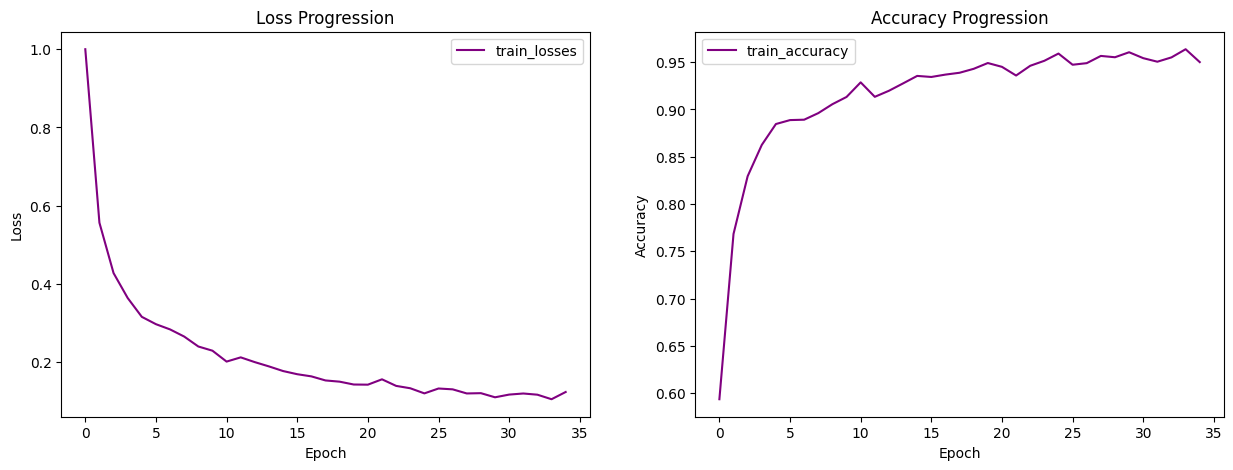

In [33]:
model = build_model(training_audio_features,
                    non_audio_df['train']['continent'],
                    learning_rate=0.001)

history = model.fit(
   x={
      'Continents': non_audio_df['train']['continent'],
      'Audio_Features': training_audio_features
   },
   y=audio_df['train']['label'],
   sample_weight=training_sample_weights,
   epochs=35,
   batch_size=32,
   verbose=1)

visualize(history)

In [34]:
train_yhat = model.predict({'Continents': non_audio_df['train']['continent'],
                            'Audio_Features': training_audio_features
                            })

train_yhat_result = np.argmax(train_yhat, axis=-1)

model.evaluate({'Continents': non_audio_df['train']['continent'],
                'Audio_Features': training_audio_features},
               audio_df['train']['label'])[-1]

225/225 [==============================] - 1s 3ms/step - loss: 0.1324 - accuracy: 0.9751 - weighted_accuracy: 0.9751


0.9751147031784058

In [35]:
test_yhat = model.predict({'Continents': non_audio_df['test']['continent'],
                          'Audio_Features': test_audio_features
                          })

test_yhat_result = np.argmax(test_yhat, axis=-1)

model.evaluate({'Continents': non_audio_df['test']['continent'],
                'Audio_Features': test_audio_features},
               audio_df['test']['label'])[-1]

107/107 [==============================] - 0s 3ms/step - loss: 0.3671 - accuracy: 0.9098 - weighted_accuracy: 0.9098


0.909758985042572

### evaluate the results

In [36]:
print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.98      0.98      0.98      2635
      comsan       0.96      0.98      0.97      2196
     eaywag1       0.99      0.97      0.98      2362

    accuracy                           0.98      7193
   macro avg       0.97      0.98      0.97      7193
weighted avg       0.98      0.98      0.98      7193



In [37]:
print('Test classification Report \n')
print(classification_report(audio_df['test']['label'], test_yhat_result, target_names=classes))

Test classification Report 

              precision    recall  f1-score   support

      barswa       0.93      0.91      0.92      1409
      comsan       0.89      0.90      0.90       924
     eaywag1       0.90      0.91      0.91      1069

    accuracy                           0.91      3402
   macro avg       0.91      0.91      0.91      3402
weighted avg       0.91      0.91      0.91      3402



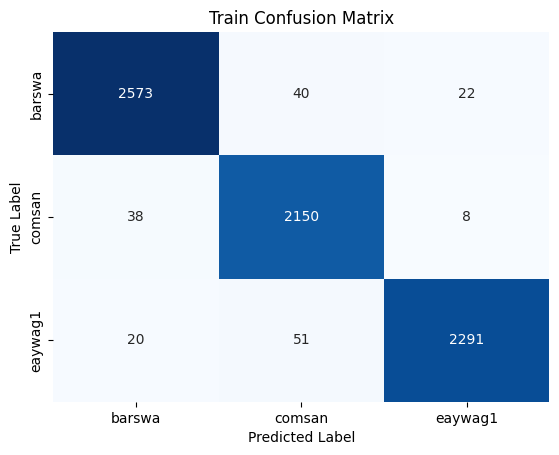

In [38]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

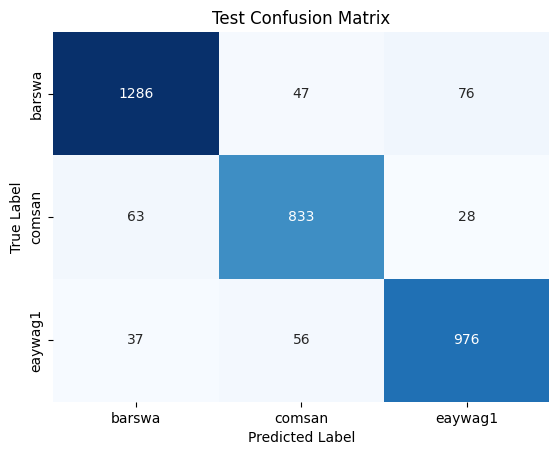

In [39]:
test_cm = tf.math.confusion_matrix(audio_df['test']['label'], test_yhat_result)

ax = sns.heatmap(test_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Test Confusion Matrix')
plt.show()